In [1]:
from PIL import Image
import torch
from models.model import MyModel

/opt/conda/envs/mmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
args = argparse.Namespace(
    # Model setting
    float_type=torch.bfloat16,
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-large",
    language_model_train=False,
    ffn=True,
    transformer_d_model=768,
    transformer_d_ff=3072,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=12,
    loc_vocab_size=1600,
    additional_vocab_size=10000,
    vae_ckpt_path='',
    max_source_length=512,
    max_target_length=512,
    # Train setting
    phase="pretrain", 
    loss='CrossEntropy',
    # Dir setting
    root_dir="/data01/",
    result_dir="results/pretrain/cc3m_cc12m_imagenet_imagenet21k_places365_redcaps_sun397/enc2_dec12/Linear20",
)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model = MyModel(args).to(device)
model.load(result_name='epoch_4.pth')

In [5]:
from transformers import AutoTokenizer
from torchvision import transforms
src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_source_length)
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_target_length, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(args.loc_vocab_size)] + [f"<add_{i}>" for i in range(args.additional_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [6]:
import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu().numpy()
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

In [7]:
def show_result(dataset, idx=10, src_txt=None):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    if src_txt is not None:
        src_text = torch.tensor(src_tokenizer.encode(src_txt)[:-1])
    else:
        print(src_text)
        print('src_text:', src_tokenizer.decode(src_text))
        print(tgt_text)
        print('tgt_text:', tgt_tokenizer.decode(tgt_text[:-1]))
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        src_text = src_text.unsqueeze(0).to(device)
        src_attention_mask = torch.ones_like(src_text).to(device)

        display(custom_to_pil(src_image[0]))
        output = model(src_image, src_text, src_attention_mask, return_loss=False, num_beams=4)
        preds = tgt_tokenizer.batch_decode(output[:,1:-1])
        print('pred:', preds[0])

# SUN397

In [8]:
from data import get_dataset
dataset = get_dataset(args, dataset_name='sun397', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

tensor([  389,  1023,    13, 32099,     5])
src_text: An image of<extra_id_0>.
tensor([32099,  1207, 32098,     1])
tgt_text: <extra_id_0> bar<extra_id_1>


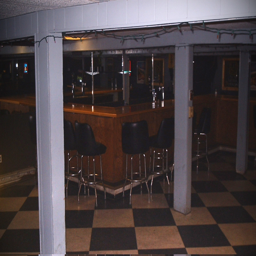

pred: <extra_id_0> bar<extra_id_1>


In [16]:
# Good: 1000, Bad: 1500
show_result(dataset, idx=1000)

# ImageNet

In [ ]:
from data import get_dataset
# train_dataset = get_dataset(args, dataset_name='imagenet', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='imagenet', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

In [ ]:
show_result(val_dataset, idx=15)

## ImageNet21K

In [152]:
from data import get_dataset
val_dataset = get_dataset(args, dataset_name='imagenet21k', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

tensor([32099,  1202,    13,  5989,     5])
src_text: <extra_id_0> photo of swimming.
tensor([   71, 32098,     1])
tgt_text: A<extra_id_1>


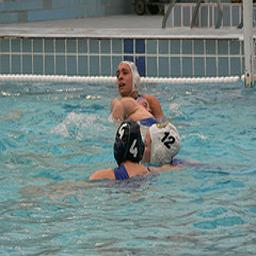

pred: A<extra_id_1>


In [159]:
# Good: 200, Bad: 900
show_result(val_dataset, idx=200)

# Places365

In [160]:
from data import get_dataset
# train_dataset = get_dataset(args, dataset_name='places365', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='places365', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

tensor([32099,  1023,    24,  1267,     3,     9,   835,  7472,     5])
src_text: <extra_id_0> image that shows aqueduct.
tensor([  389, 32098,     1])
tgt_text: An<extra_id_1>


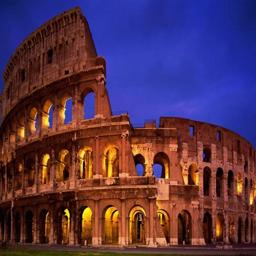

pred: An<extra_id_1>


In [185]:
# Good: 500, Bad: 10
show_result(val_dataset, idx=500)

# RedCaps

In [186]:
from data import get_dataset
dataset = get_dataset(args, dataset_name="redcaps", phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

tensor([  101,   189,  3009,   764,    28,     3, 32099,  5261,     5,  5066,
           27,  1205,    34,    42,    19, 32098,  1399,    58])
src_text: Wethstone came with <extra_id_0> crack. Should I return it or is<extra_id_1> fine?
tensor([32099,     9, 32098,    34, 32097,     1])
tgt_text: <extra_id_0>a<extra_id_1> it<extra_id_2>


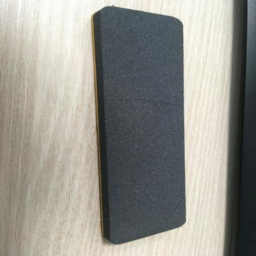

pred: <extra_id_0>a<extra_id_1> it<extra_id_2>


In [214]:
# Good: 100, Bad: 3
show_result(dataset, idx=100)

# CC3M

In [8]:
from data import get_dataset
dataset = get_dataset(args, dataset_name='cc3m', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

tensor([  204, 32099,  3427,  6323,   507,  1458,  3710,    45,     8,  7956,
           57,  3924,  2377])
src_text: 2<extra_id_0> prime minister 183034 from the portrait by painting artist
tensor([32099,   727, 32098,     1])
tgt_text: <extra_id_0>nd<extra_id_1>


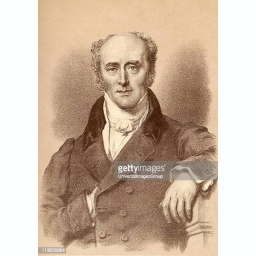

pred: <extra_id_0>nd<extra_id_1>


In [9]:
# Good: 10, Bad: 20
show_result(dataset, idx=20)

# CC12M

In [10]:
from data import get_dataset
dataset = get_dataset(args, dataset_name="cc12m", phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

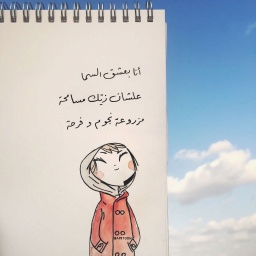

pred: <extra_id_0> paper


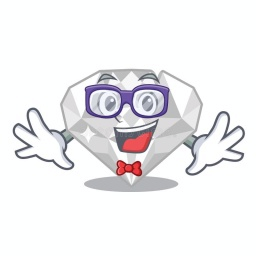

pred: <extra_id_0> heart


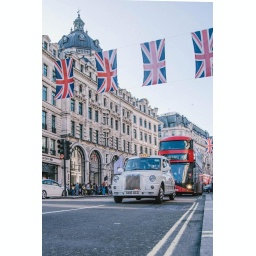

pred: <extra_id_0> city


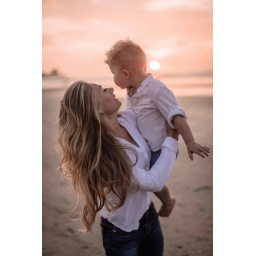

pred: <extra_id_0> sunset


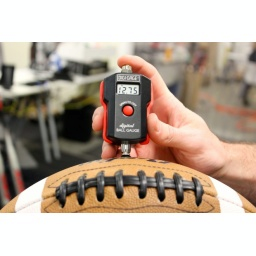

pred: <extra_id_0> ball


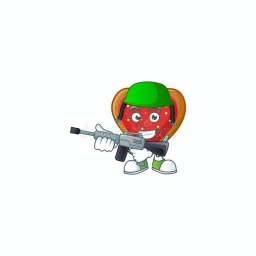

pred: <extra_id_0> cartoon


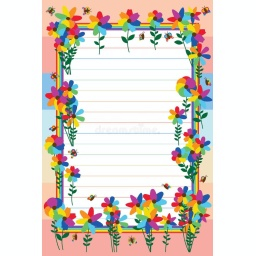

pred: <extra_id_0> paper


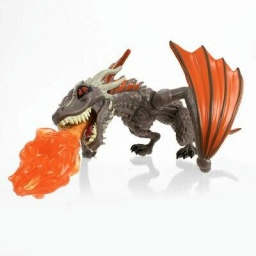

pred: <extra_id_0> dragon


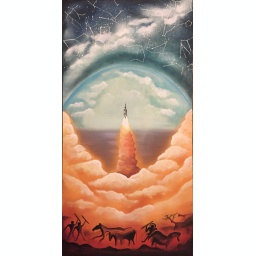

pred: <extra_id_0> clouds


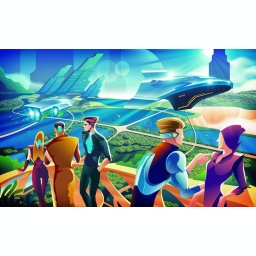

pred: <extra_id_0> drone


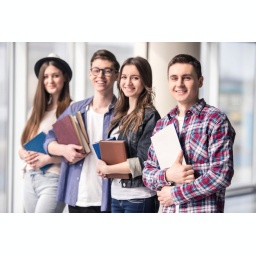

pred: <extra_id_0> student


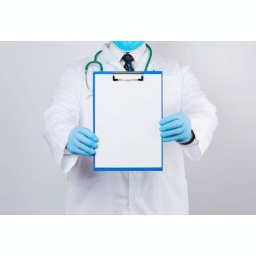

pred: <extra_id_0> doctor


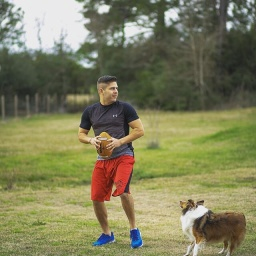

pred: <extra_id_0> man


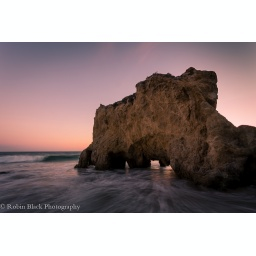

pred: <extra_id_0> ocean


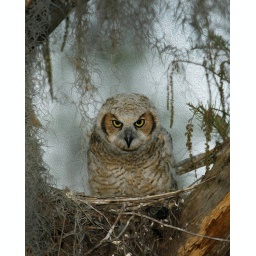

pred: <extra_id_0> bird


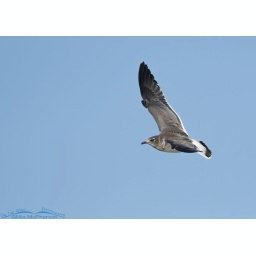

pred: <extra_id_0> bird


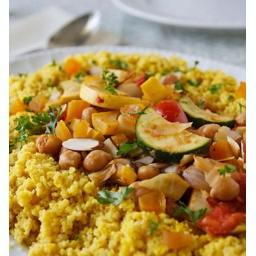

pred: <extra_id_0> curry


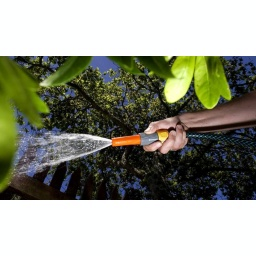

pred: <extra_id_0> soil


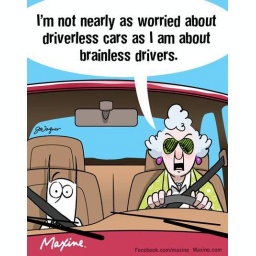

pred: <extra_id_0> cartoon


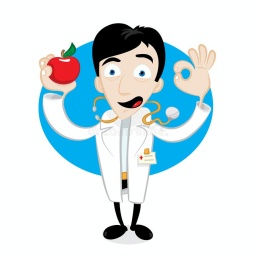

pred: <extra_id_0> doctor


In [44]:
# Good: 21, Bad: 10
for i in range(440,460):
    show_result(dataset, idx=i, src_txt='An image of<extra_id_0>')